In [3]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from keras.layers import Add, Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
low_img_folder = '/content/drive/MyDrive/Colab Notebooks/low'
high_img_folder = '/content/drive/MyDrive/Colab Notebooks/high'

In [17]:
def preprocess_images(folder_path, target_size):
    image_list = []

    # Loop through each file in the directory
    for file in tqdm(sorted(os.listdir(folder_path))):
        if file.endswith((".png", ".jpeg")):
            file_path = os.path.join(folder_path, file)
            img = cv.imread(file_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
            img = cv.resize(img, target_size)
            img = img.astype('float32') / 255.0
            image_list.append(img)

    return np.array(image_list)

target_size = (256, 256)
low_res_images = preprocess_images(low_img_folder, target_size)
high_res_images = preprocess_images(high_img_folder, target_size)

100%|██████████| 485/485 [00:11<00:00, 43.51it/s]


In [18]:
from sklearn.model_selection import train_test_split
low_res_train, low_res_val, high_res_train, high_res_val = train_test_split(low_res_images, high_res_images, test_size=0.1, random_state=48)

In [19]:
from tensorflow.keras.layers import Conv2D, Add, Activation

def build_residual_block(input_layer, num_filters):
    conv_layer = Conv2D(num_filters, kernel_size=3, activation='relu', padding='same')(input_layer)
    conv_layer = Conv2D(num_filters, kernel_size=3, activation=None, padding='same')(conv_layer)
    add_layer = Add()([conv_layer, input_layer])
    output_layer = Activation('relu')(add_layer)
    return output_layer


In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model

def create_unet_model(input_shape=(256, 256, 3)):
    input_layer = Input(shape=input_shape)

    encoder1 = Conv2D(32, 3, activation='relu', padding='same')(input_layer)
    encoder1 = build_residual_block(encoder1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(encoder1)

    encoder2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    encoder2 = build_residual_block(encoder2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(encoder2)

    encoder3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    encoder3 = build_residual_block(encoder3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(encoder3)

    encoder4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    encoder4 = build_residual_block(encoder4, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(encoder4)

    bottleneck = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    bottleneck = build_residual_block(bottleneck, 512)

    upsample1 = concatenate([UpSampling2D(size=(2, 2))(bottleneck), encoder4], axis=-1)
    decoder1 = Conv2D(256, 3, activation='relu', padding='same')(upsample1)
    decoder1 = build_residual_block(decoder1, 256)

    upsample2 = concatenate([UpSampling2D(size=(2, 2))(decoder1), encoder3], axis=-1)
    decoder2 = Conv2D(128, 3, activation='relu', padding='same')(upsample2)
    decoder2 = build_residual_block(decoder2, 128)

    upsample3 = concatenate([UpSampling2D(size=(2, 2))(decoder2), encoder2], axis=-1)
    decoder3 = Conv2D(64, 3, activation='relu', padding='same')(upsample3)
    decoder3 = build_residual_block(decoder3, 64)

    upsample4 = concatenate([UpSampling2D(size=(2, 2))(decoder3), encoder1], axis=-1)
    decoder4 = Conv2D(32, 3, activation='relu', padding='same')(upsample4)
    decoder4 = build_residual_block(decoder4, 32)

    output_layer = Conv2D(3, 1, activation='sigmoid')(decoder4)

    model = Model(inputs=[input_layer], outputs=[output_layer])

    return model


In [21]:
lab_model = create_unet_model()
lab_model.compile(optimizer=Adam(learning_rate=1e-4, clipvalue=1.0), loss=MeanAbsoluteError())

tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_session = tf.compat.v1.InteractiveSession(config=tf_config)
lab_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d_1[0][0]']            
                                                                                              

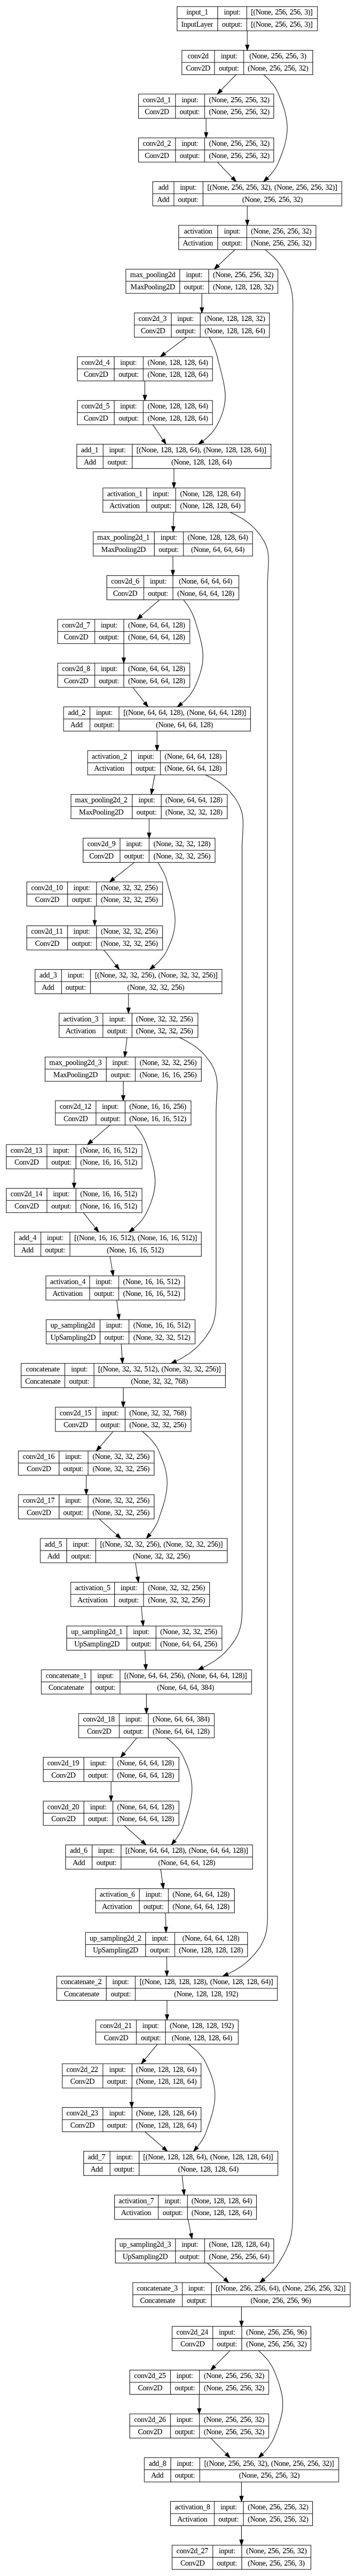

In [24]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Save the model architecture visualization.
plot_model(lab_model, to_file='unet_model_visual.png', show_shapes=True, show_layer_names=True)

# Display the saved image using Matplotlib
img = plt.imread('unet_model_visual.png')
plt.figure(figsize=(100, 80))
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
lab_model.fit(low_res_train, high_res_train,
              epochs=1, batch_size=2)


193/218 [=========================>....] - ETA: 3:06 - loss: 0.0689

In [ ]:
predictions = lab_model.predict(low_res_val, verbose=0)

psnr_values = [psnr(true_img, pred_img) for true_img, pred_img in zip(high_res_val, predictions)]

average_psnr = np.mean(psnr_values)
print(f'Mean PSNR score: {average_psnr}')


In [ ]:
import numpy as np
import tensorflow as tf

def calculate_metrics(true_images, predicted_images):
    psnr_values = []
    mse_values=[]
    mae_values=[]

    for true, pred in zip(true_images, predicted_images):
        psnr = tf.image.psnr(true, pred, max_val=1.0).numpy()
        psnr_values.append(psnr)

    return np.mean(psnr_values)

predictions = lab_model.predict(low_images, verbose=0)

psnr_value = calculate_metrics(high_images, predictions)

# Print the PSNR value
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_value}')
print(f'Mean Squared Error (MSE) values: {mse_values}')
print(f'Mean Absolute Error (MAE) values: {mae_values}')

print("---IMAGE DENOISING PROJECT SUCCESSFULLY COMPLETED---")


